In [1]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install
!pip install -q transformers
!pip install -q datasets jiwer

     |████████████████████████████████| 4.7 MB 29.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.7 MB/s 
     |████████████████████████████████| 120 kB 67.2 MB/s 
     |████████████████████████████████| 365 kB 19.3 MB/s 
     |████████████████████████████████| 115 kB 73.6 MB/s 
     |████████████████████████████████| 212 kB 57.5 MB/s 
     |████████████████████████████████| 127 kB 64.4 MB/s 
     |████████████████████████████████| 1.4 MB 59.6 MB/s 
     |████████████████████████████████| 2.3 MB 53.5 MB/s 
     |████████████████████████████████| 104 kB 70.0 MB/s 


In [3]:
# import
from transformers import TrainingArguments, Trainer, ViTFeatureExtractor, BertTokenizer, VisionEncoderDecoderModel, AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from datasets import load_dataset, DatasetDict

In [4]:
# variables
# model names
vision_model = "google/vit-large-patch32-384"
language_model = "bert-base-multilingual-uncased"

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

We split up the data into training + testing, using sklearn's `train_test_split` function.

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [5]:
# tokenizer for text
tokenizer =  AutoTokenizer.from_pretrained(language_model)
# feature extractor for image
feature_extractor = ViTFeatureExtractor.from_pretrained(vision_model)

Let's initialize the training and evaluation datasets:

In [6]:
hf_data_sroie = load_dataset('priyank-m/SROIE_2019_text_recognition')
hf_data_sroie

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/priyank-m___imagefolder/priyank-m--SROIE_2019_text_recognition-3e9f1324f13c6c51/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 33626
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 18704
    })
})

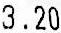

In [14]:
# test image
image = hf_data_sroie['train'][0]['image']
image

In [15]:
# squeeze demo
pix = feature_extractor(image, return_tensors="pt").pixel_values
print(pix.shape)
type(pix.squeeze())
pix.squeeze().shape

torch.Size([1, 3, 384, 384])


torch.Size([3, 384, 384])

In [37]:
small_hf_data_sroie = hf_data_sroie['train'].shuffle().select([1])
small_hf_data_sroie = DatasetDict({'train':small_hf_data_sroie, 'test':small_hf_data_sroie})
small_hf_data_sroie

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 1
    })
})

Let's verify an example from the training dataset:

## load and prep uploaded datasets

In [38]:
def prep_function(examples, max_target_length=128):
    pixel_values = feature_extractor(examples['image'], return_tensors="pt").pixel_values
    labels = tokenizer(examples['text'], padding="max_length", max_length=max_target_length).input_ids
    labels = [label if label != tokenizer.pad_token_id else -100 for label in labels]
    encoding = {"pixel_values": list(pixel_values.squeeze()), "labels": torch.tensor(labels)}

    # here pixel_values is torch.tensor, but once saved in the dataset it becomes a dict
    return encoding

In [39]:
# try on-the-fly preprocessing
# #dataset.set_format(type=dataset.format["type"], columns=columns, format_kwargs=dataset.format["format_kwargs"])
# hf_data_sroie.set_transform(prep_function)
# hf_data_sroie.set_format(type=hf_data_sroie.format["type"], columns=columns, format_kwargs=dataset.format["format_kwargs"])

# train_dataset = hf_data_sroie['train'].select(range(5))
# eval_dataset = hf_data_sroie['test'].select(range(5))

In [40]:
# apply preprocessing
encoded_dataset = small_hf_data_sroie.map(lambda examples: prep_function(examples)) # batched+true somehow didnt work for the tensors type that we return in the dicitonary
train_dataset = encoded_dataset['train']
eval_dataset = encoded_dataset['test']

  0%|          | 0/1 [00:00<?, ?ex/s]

In [41]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1
Number of validation examples: 1


In [42]:
# encoding = train_dataset[0]
# for k,v in encoding.items():
#   print(k, v.shape)

We can also check the original image and decode the labels:

In [45]:
# # image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
# a = train_dataset.select([1])
# a[0]['pixel_values'].shape

In [46]:
# labels = train_dataset['labels'][0]
# labels[labels == -100] = tokenizer.pad_token_id
# labels

In [47]:
# label_str = tokenizer.decode(labels, skip_special_tokens=True)
# print(label_str)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
#model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

# defining the model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    vision_model, language_model
)

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [49]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = tokenizer.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [55]:
from datasets import load_metric

cer_metric = load_metric("cer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [56]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [63]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

num_train_epochs=200


training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    fp16=True, 
    output_dir="/content/drive/MyDrive/model_storage/", 
    logging_steps=10,
    save_steps=1000, # 1 epoch 
    eval_steps=5, # after these many steps/batches the eval runs and prints the loss
    num_train_epochs=num_train_epochs,
    learning_rate=5e-6
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [64]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    #tokenizer=prep_function,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: image, text. If image, text are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1
  Num Epochs = 200
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 200


Step,Training Loss,Validation Loss,Cer
5,No log,1.676660,17.142857
10,2.394700,2.168701,3.857143
15,2.394700,1.803149,4.000000
20,2.341800,1.008398,1.428571
25,2.341800,0.922314,0.571429
30,1.700700,1.093652,0.571429
35,1.700700,1.103687,0.571429
40,1.527800,1.156445,0.571429
45,1.527800,1.341901,0.571429
50,1.092500,1.147968,0.571429


The following columns in the evaluation set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: image, text. If image, text are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1
  Batch size = 2
The following columns in the evaluation set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: image, text. If image, text are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1
  Batch size = 2
The following columns in the evaluation set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: image, text. If image, text are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1
  Batch size = 2
The fol

TrainOutput(global_step=200, training_loss=0.9222178661823273, metrics={'train_runtime': 127.4369, 'train_samples_per_second': 1.569, 'train_steps_per_second': 1.569, 'total_flos': 2.23784416935936e+17, 'train_loss': 0.9222178661823273, 'epoch': 200.0})

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
# inference
import requests
from PIL import Image

# # let's perform inference on an image
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
file_name = "c04-110-02.jpg"
image = Image.open('/content/IAM/image/'+file_name).convert("RGB")

In [65]:
#train_dataset[0]['pixel_values'].shape
pix = torch.tensor(train_dataset['pixel_values'][0])
pixel_values = torch.unsqueeze(input=pix, dim=0)
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)

In [67]:
train_dataset['text'][0]

'439.00'

In [68]:
# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values, max_new_tokens=50)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

439.
